In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
import scipy as sp
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
lc1 = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc')
lc2 = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc')
lc3 = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.lc')
lc4 = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.lc')
lc1_data = lc1[1].data
lc2_data = lc2[1].data
lc3_data = lc3[1].data
lc4_data = lc4[1].data

**Marking where the grb starts and ends in each quadrant**

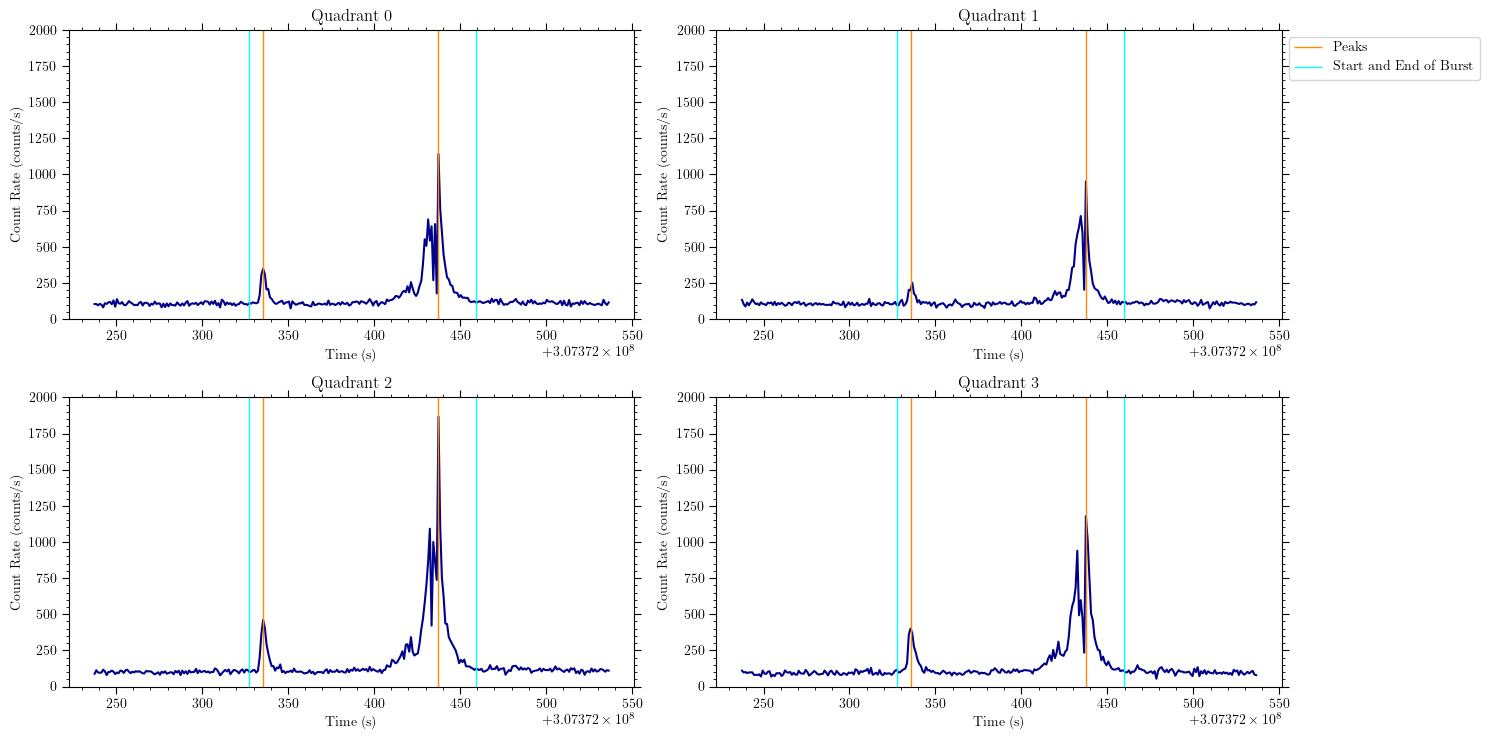

In [3]:
plt.figure(figsize=(15,7.5))
plt.subplot(2,2,1)
max_lc1 = int(np.where(lc1_data['RATE'] == np.max(lc1_data['RATE']))[0])
plt.plot(lc1_data['TIME'][max_lc1-200:max_lc1+100], lc1_data['RATE'][max_lc1-200:max_lc1+100], color='darkblue')
plt.ylim(0,2000)
plt.vlines(x = [lc1_data['TIME'][max_lc1], lc1_data['TIME'][max_lc1-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
plt.vlines(x = [lc1_data['TIME'][max_lc1+22], lc1_data['TIME'][max_lc1-110]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
#plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title("Quadrant 0")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(2,2,2)
max_lc2 = int(np.where(lc2_data['RATE'] == np.max(lc2_data['RATE']))[0])
plt.plot(lc2_data['TIME'][max_lc2-200:max_lc2+100], lc2_data['RATE'][max_lc2-200:max_lc2+100], color='darkblue')
plt.ylim(0,2000)
plt.vlines(x = [lc2_data['TIME'][max_lc2], lc2_data['TIME'][max_lc2-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
plt.vlines(x = [lc2_data['TIME'][max_lc2+22], lc2_data['TIME'][max_lc2-110]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title("Quadrant 1")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(2,2,3)
max_lc3 = int(np.where(lc3_data['RATE'] == np.max(lc3_data['RATE']))[0])
plt.plot(lc3_data['TIME'][max_lc3-200:max_lc3+100], lc3_data['RATE'][max_lc3-200:max_lc3+100], color='darkblue')
plt.ylim(0,2000)
plt.vlines(x = [lc3_data['TIME'][max_lc3], lc3_data['TIME'][max_lc3-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
plt.vlines(x = [lc3_data['TIME'][max_lc3+22], lc3_data['TIME'][max_lc3-110]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
#plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title("Quadrant 2")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(2,2,4)
max_lc4 = int(np.where(lc4_data['RATE'] == np.max(lc4_data['RATE']))[0])
plt.plot(lc4_data['TIME'][max_lc4-200:max_lc4+100], lc4_data['RATE'][max_lc4-200:max_lc4+100], color='darkblue')
plt.ylim(0,2000)
plt.vlines(x = [lc4_data['TIME'][max_lc4], lc4_data['TIME'][max_lc4-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
plt.vlines(x = [lc4_data['TIME'][max_lc4+22], lc4_data['TIME'][max_lc4-110]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
#plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.title("Quadrant 3")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.tight_layout()

In [4]:
#time of grb
duration = lc4_data['TIME'][max_lc4+22] - lc4_data['TIME'][max_lc4-110]
print("The duration of the GRB is " + str(duration) + " seconds")
print(max_lc4)
print(max_lc1)

The duration of the GRB is 132.0 seconds
1801
1801


**Filtering and detrending the data**

In [5]:
#applying the savgol filter and detrending the data

lc1_filtered = lc1_data['RATE']
lc2_filtered = lc2_data['RATE']
lc3_filtered = lc3_data['RATE']
lc4_filtered = lc4_data['RATE']

lc1_filtered[max_lc1-110:max_lc1+22] -= (np.median(lc1_filtered[:max_lc1-110])+np.median(lc1_filtered[max_lc1+22:max_lc1+3000]))/2
lc2_filtered[max_lc2-110:max_lc2+22] -= (np.median(lc2_filtered[:max_lc2-110])+np.median(lc2_filtered[max_lc2+22:max_lc2+3000]))/2
lc3_filtered[max_lc3-110:max_lc3+22] -= (np.median(lc3_filtered[:max_lc3-110])+np.median(lc3_filtered[max_lc3+22:max_lc3+3000]))/2
lc4_filtered[max_lc4-110:max_lc4+22] -= (np.median(lc4_filtered[:max_lc4-110])+np.median(lc4_filtered[max_lc4+22:max_lc4+3000]))/2

lc1_filtered[:max_lc1-110] -= savgol_filter(lc1_filtered[:max_lc1-110], 10, 3)
lc2_filtered[:max_lc2-110] -= savgol_filter(lc2_filtered[:max_lc2-110], 10, 3)
lc3_filtered[:max_lc3-110] -= savgol_filter(lc3_filtered[:max_lc3-110], 10, 3)
lc4_filtered[:max_lc4-110] -= savgol_filter(lc4_filtered[:max_lc4-110], 10, 3)
lc1_filtered[max_lc1+22:] -= savgol_filter(lc1_filtered[max_lc1+22:], 10, 3)
lc2_filtered[max_lc2+22:] -= savgol_filter(lc2_filtered[max_lc2+22:], 10, 3)
lc3_filtered[max_lc3+22:] -= savgol_filter(lc3_filtered[max_lc3+22:], 10, 3)
lc4_filtered[max_lc4+22:] -= savgol_filter(lc4_filtered[max_lc4+22:], 101, 3)


plt.figure(figsize=(16,12))
plt.subplot(4,1,1)
plt.plot(lc1_data['TIME'], lc1_filtered, color='mediumslateblue')
plt.title("Detrended Quadrant 0")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(4,1,2)
plt.plot(lc2_data['TIME'], lc2_filtered, color='mediumslateblue')
plt.title("Detrended Quadrant 1")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(4,1,3)
plt.plot(lc3_data['TIME'], lc3_filtered, color='mediumslateblue')
plt.title("Detrended Quadrant 2")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.subplot(4,1,4)
plt.plot(lc4_data['TIME'], lc4_filtered, color='mediumslateblue')
plt.title("Detrended Quadrant 3")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (counts/s)")
plt.tight_layout()
plt.show()

ValueError: window_length must be odd.

**Estimating the noise and calculating SNR**

In [ ]:
#method 1 - using RMS value of noise and peak value of signal
m1_noise_lc1 = (np.sqrt(np.mean(lc1_filtered[:max_lc1-110]**2))+np.sqrt(np.mean(lc1_filtered[max_lc1+22:]**2)))/2
m1_noise_lc2 = (np.sqrt(np.mean(lc2_filtered[:max_lc2-110]**2))+np.sqrt(np.mean(lc2_filtered[max_lc2+22:]**2)))/2
m1_noise_lc3 = (np.sqrt(np.mean(lc3_filtered[:max_lc3-110]**2))+np.sqrt(np.mean(lc3_filtered[max_lc3+22:]**2)))/2
m1_noise_lc4 = (np.sqrt(np.mean(lc4_filtered[:max_lc4-110]**2))+np.sqrt(np.mean(lc4_filtered[max_lc4+22:]**2)))/2

m1_signal_lc1 = np.max(lc1_filtered)
m1_signal_lc2 = np.max(lc2_filtered)
m1_signal_lc3 = np.max(lc3_filtered)
m1_signal_lc4 = np.max(lc4_filtered)

m1_snr_lc1 = m1_signal_lc1/m1_noise_lc1
m1_snr_lc2 = m1_signal_lc2/m1_noise_lc2
m1_snr_lc3 = m1_signal_lc3/m1_noise_lc3
m1_snr_lc4 = m1_signal_lc4/m1_noise_lc4

print("The SNR of the GRB in Quadrant 0 is " + str(m1_snr_lc1))
print("The SNR of the GRB in Quadrant 1 is " + str(m1_snr_lc2))
print("The SNR of the GRB in Quadrant 2 is " + str(m1_snr_lc3))
print("The SNR of the GRB in Quadrant 3 is " + str(m1_snr_lc4))

The SNR of the GRB in Quadrant 0 is 102.8724121524228
The SNR of the GRB in Quadrant 1 is 86.79547008815133
The SNR of the GRB in Quadrant 2 is 187.52052392861668
The SNR of the GRB in Quadrant 3 is 103.45344614038416


In [ ]:
#method 2 - using mean of absolute value of noise and peak value of signal
m2_noise_lc1 = (np.mean(np.abs(lc1_filtered[:max_lc1-110]))+np.mean(np.abs(lc1_filtered[max_lc1+22:])))/2
m2_noise_lc2 = (np.mean(np.abs(lc2_filtered[:max_lc2-110]))+np.mean(np.abs(lc2_filtered[max_lc2+22:])))/2
m2_noise_lc3 = (np.mean(np.abs(lc3_filtered[:max_lc3-110]))+np.mean(np.abs(lc3_filtered[max_lc3+22:])))/2
m2_noise_lc4 = (np.mean(np.abs(lc4_filtered[:max_lc4-110]))+np.mean(np.abs(lc4_filtered[max_lc4+22:])))/2

m2_signal_lc1 = np.max(lc1_filtered)
m2_signal_lc2 = np.max(lc2_filtered)
m2_signal_lc3 = np.max(lc3_filtered)
m2_signal_lc4 = np.max(lc4_filtered)

m2_snr_lc1 = m2_signal_lc1/m2_noise_lc1
m2_snr_lc2 = m2_signal_lc2/m2_noise_lc2
m2_snr_lc3 = m2_signal_lc3/m2_noise_lc3
m2_snr_lc4 = m2_signal_lc4/m2_noise_lc4

print("The SNR of the GRB in Quadrant 0 is " + str(m2_snr_lc1))
print("The SNR of the GRB in Quadrant 1 is " + str(m2_snr_lc2))
print("The SNR of the GRB in Quadrant 2 is " + str(m2_snr_lc3))
print("The SNR of the GRB in Quadrant 3 is " + str(m2_snr_lc4))

The SNR of the GRB in Quadrant 0 is 133.22374193057215
The SNR of the GRB in Quadrant 1 is 111.52793957279063
The SNR of the GRB in Quadrant 2 is 241.29866919123577
The SNR of the GRB in Quadrant 3 is 135.85514300781531


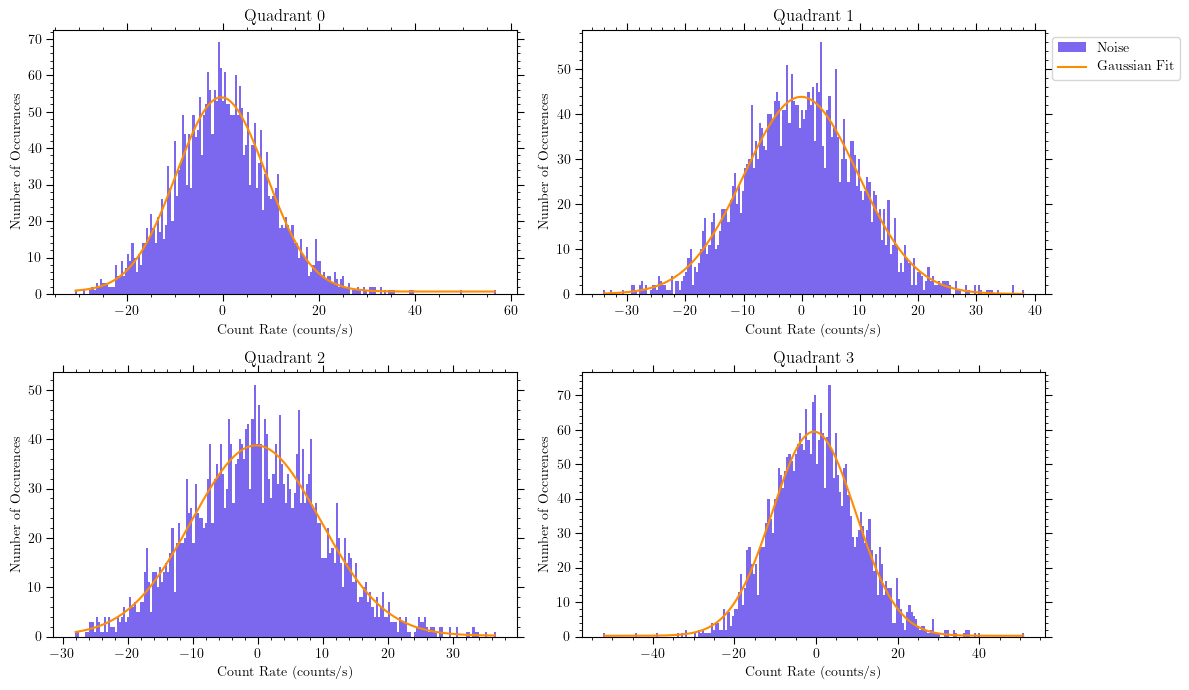

The SNR of the GRB in Quadrant 0 is 37.3647266046112
The SNR of the GRB in Quadrant 1 is 28.83930618238178
The SNR of the GRB in Quadrant 2 is 59.851519260828766
The SNR of the GRB in Quadrant 3 is 35.96614905997737


In [ ]:
#modelling the noise as a gaussian
def f(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c
p0 = [20, 0, 1, 0]

#quadrant 0
n_lc1, bins_lc1 = np.histogram(lc1_filtered[max_lc1+22:max_lc1+3000], bins=200)
bin_centres_lc1 = np.array([0.5 * (bins_lc1[i] + bins_lc1[i+1]) for i in range(len(bins_lc1)-1)])
popt_lc1, pcov_lc1 = curve_fit(f, bin_centres_lc1, n_lc1, p0)

#quadrant 1
n_lc2, bins_lc2 = np.histogram(lc2_filtered[max_lc2+22:max_lc2+3000], bins=200)
bin_centres_lc2 = np.array([0.5 * (bins_lc2[i] + bins_lc2[i+1]) for i in range(len(bins_lc2)-1)])
popt_lc2, pcov_lc2 = curve_fit(f, bin_centres_lc2, n_lc2, p0)

#quadrant 2
n_lc3, bins_lc3 = np.histogram(lc3_filtered[max_lc3+22:max_lc3+3000], bins=200)
bin_centres_lc3 = np.array([0.5 * (bins_lc3[i] + bins_lc3[i+1]) for i in range(len(bins_lc3)-1)])
popt_lc3, pcov_lc3 = curve_fit(f, bin_centres_lc3, n_lc3, p0)

#quadrant 3
n_lc4, bins_lc4 = np.histogram(lc4_filtered[max_lc4+22:max_lc4+3000], bins=200)
bin_centres_lc4 = np.array([0.5 * (bins_lc4[i] + bins_lc4[i+1]) for i in range(len(bins_lc4)-1)])
popt_lc4, pcov_lc4 = curve_fit(f, bin_centres_lc4, n_lc4, p0)


plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.hist(lc1_filtered[max_lc1+22:max_lc1+3000], bins = 200, color='mediumslateblue')
plt.plot(bin_centres_lc1, f(bin_centres_lc1, *popt_lc1), color='darkorange')
plt.title("Quadrant 0")
plt.xlabel("Count Rate (counts/s)")
plt.ylabel("Number of Occurences")
plt.subplot(2,2,2)
plt.hist(lc2_filtered[max_lc2+22:max_lc2+3000], bins = 200, color='mediumslateblue', label='Noise')
plt.plot(bin_centres_lc2, f(bin_centres_lc2, *popt_lc2), color='darkorange', label='Gaussian Fit')
plt.title("Quadrant 1")
plt.xlabel("Count Rate (counts/s)")
plt.ylabel("Number of Occurences")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.subplot(2,2,3)
plt.hist(lc3_filtered[max_lc3+22:max_lc3+3000], bins = 200, color='mediumslateblue')
plt.plot(bin_centres_lc3, f(bin_centres_lc3, *popt_lc3), color='darkorange')
plt.title("Quadrant 2")
plt.xlabel("Count Rate (counts/s)")
plt.ylabel("Number of Occurences")
plt.subplot(2,2,4)
plt.hist(lc4_filtered[max_lc4+22:max_lc4+3000], bins = 200, color='mediumslateblue')
plt.plot(bin_centres_lc4, f(bin_centres_lc4, *popt_lc4), color='darkorange')
plt.title("Quadrant 3")
plt.xlabel("Count Rate (counts/s)")
plt.ylabel("Number of Occurences")
plt.tight_layout()
plt.show()

#method 3 - using gaussian fit to noise and peak value of signal 
m3_noise_lc1 = popt_lc1[1]+3*popt_lc1[2]
m3_noise_lc2 = popt_lc2[1]+3*popt_lc2[2]
m3_noise_lc3 = popt_lc3[1]+3*popt_lc3[2]
m3_noise_lc4 = popt_lc4[1]+3*popt_lc4[2]

m3_signal_lc1 = np.max(lc1_filtered)
m3_signal_lc2 = np.max(lc2_filtered)
m3_signal_lc3 = np.max(lc3_filtered)
m3_signal_lc4 = np.max(lc4_filtered)

m3_snr_lc1 = m3_signal_lc1/m3_noise_lc1
m3_snr_lc2 = m3_signal_lc2/m3_noise_lc2
m3_snr_lc3 = m3_signal_lc3/m3_noise_lc3
m3_snr_lc4 = m3_signal_lc4/m3_noise_lc4

print("The SNR of the GRB in Quadrant 0 is " + str(m3_snr_lc1))
print("The SNR of the GRB in Quadrant 1 is " + str(m3_snr_lc2))
print("The SNR of the GRB in Quadrant 2 is " + str(m3_snr_lc3))
print("The SNR of the GRB in Quadrant 3 is " + str(m3_snr_lc4))


In [ ]:
#method 4 adding the counts in the peak and noise regions
m4_noise_lc1 = duration*(np.mean(np.abs(lc1_filtered[:max_lc1-110]))+np.mean(np.abs(lc1_filtered[max_lc1+22:])))/2
m4_noise_lc2 = duration*(np.mean(np.abs(lc2_filtered[:max_lc2-110]))+np.mean(np.abs(lc2_filtered[max_lc2+22:])))/2
m4_noise_lc3 = duration*(np.mean(np.abs(lc3_filtered[:max_lc3-110]))+np.mean(np.abs(lc3_filtered[max_lc3+22:])))/2
m4_noise_lc4 = duration*(np.mean(np.abs(lc4_filtered[:max_lc4-110]))+np.mean(np.abs(lc4_filtered[max_lc4+22:])))/2

m4_signal_lc1 = np.sum(lc1_filtered[max_lc1-110:max_lc1+22])
m4_signal_lc2 = np.sum(lc2_filtered[max_lc2-110:max_lc2+22])
m4_signal_lc3 = np.sum(lc3_filtered[max_lc3-110:max_lc3+22])
m4_signal_lc4 = np.sum(lc4_filtered[max_lc4-110:max_lc4+22])

m4_snr_lc1 = m4_signal_lc1/m4_noise_lc1
m4_snr_lc2 = m4_signal_lc2/m4_noise_lc2
m4_snr_lc3 = m4_signal_lc3/m4_noise_lc3
m4_snr_lc4 = m4_signal_lc4/m4_noise_lc4

print("The SNR of the GRB in Quadrant 0 is " + str(m4_snr_lc1))
print("The SNR of the GRB in Quadrant 1 is " + str(m4_snr_lc2))
print("The SNR of the GRB in Quadrant 2 is " + str(m4_snr_lc3))
print("The SNR of the GRB in Quadrant 3 is " + str(m4_snr_lc4))

The SNR of the GRB in Quadrant 0 is 9.698732083632212
The SNR of the GRB in Quadrant 1 is 6.94840445093659
The SNR of the GRB in Quadrant 2 is 16.717092517042907
The SNR of the GRB in Quadrant 3 is 12.34727808985499


**Plotting image of the GRB**

In [ ]:
evt = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt')
data = evt[1].data
one = (np.where(data['TIME'] > int(lc1_data['TIME'][max_lc1-110])))[0]
two = (np.where(data['TIME'] < int(lc1_data['TIME'][max_lc1+22])))[0]

print(evt[1].data['TIME'][min(one)])
evt[1].data = evt[1].data[min(one):max(two)]
evt[2].data = evt[2].data[min(one):max(two)]
evt[3].data = evt[3].data[min(one):max(two)]
evt[4].data = evt[4].data[min(one):max(two)]
evt.writeto('test/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt', overwrite=True)

307372327.0291468


In [ ]:
test = fits.open('test/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt')
test.info()

Filename: test/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     112   ()      
  1  Q0            1 BinTableHDU    146   24068R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  2  Q1            1 BinTableHDU    146   24068R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  3  Q2            1 BinTableHDU    146   24068R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  4  Q3            1 BinTableHDU    146   24068R x 12C   [D, D, I, I, B, B, B, B, I, B, I, E]   
  5  VETOSPECTRUM    1 BinTableHDU     98   27513R x 4C   [D, D, 256I, B]   
  6  SSM Data      1 BinTableHDU    114   272R x 7C   [D, D, 256I, 512I, 512I, 512I, B]   
  7  TEMP          1 BinTableHDU    105   272R x 4C   [D, D, 16E, B]   
  8  Q0_GTI        1 BinTableHDU    114   154R x 2C   [1D, 1D]   
  9  Q1_GTI        1 BinTableHDU    114   154R x 2C   [1D, 1D]   
 10  Q2_GTI        1 BinTableHDU    114   183R x 2C   

In [ ]:
image_q0 = fits.open('test/image_out.img_Q0')
image_q1 = fits.open('test/image_out.img_Q1')
image_q2 = fits.open('test/image_out.img_Q2')
image_q3 = fits.open('test/image_out.img_Q3')

image_data_q0 = image_q0[1].data
image_data_q1 = image_q1[1].data
image_data_q2 = image_q2[1].data
image_data_q3 = image_q3[1].data

plt.figure(figsize=(8,8))
plt.suptitle("Quadrants of the Burst")
plt.subplot(2,2,1)
plt.imshow(image_data_q0, cmap='gist_heat')
plt.title("Quadrant 0")
plt.subplot(2,2,2)
plt.imshow(image_data_q1, cmap='gist_heat')
plt.title("Quadrant 1")
plt.subplot(2,2,3)
plt.imshow(image_data_q2, cmap='gist_heat')
plt.title("Quadrant 2")
plt.subplot(2,2,4)
plt.imshow(image_data_q3, cmap='gist_heat')
plt.title("Quadrant 3")
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'test/image_out.img_Q0'

Filename: test/dpigen_out.dph
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  Q0            1 ImageHDU        67   (64, 64)   int32   
  2  Q1            1 ImageHDU        67   (64, 64)   int32   
  3  Q2            1 ImageHDU        67   (64, 64)   int32   
  4  Q3            1 ImageHDU        67   (64, 64)   int32   
  5  FULL_DPH      1 ImageHDU        40   (128, 128)   int32   


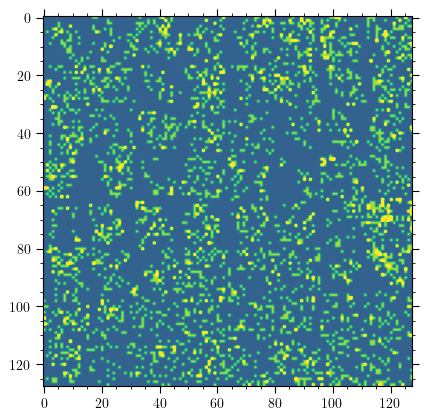

In [ ]:
dph = fits.open('test/dpigen_out.dph')
dph.info()
median, mean, std = sigma_clipped_stats(dph[5].data, sigma=3.0)
plt.imshow(dph[5].data, vmin=median-2*std, vmax=median+3*std)

Filename: test/dpigen_out.dpi
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  Q0            1 ImageHDU        67   (64, 64)   float32   
  2  Q1            1 ImageHDU        67   (64, 64)   float32   
  3  Q2            1 ImageHDU        67   (64, 64)   float32   
  4  Q3            1 ImageHDU        67   (64, 64)   float32   
  5  FULL_DPI      1 ImageHDU        40   (128, 128)   float32   


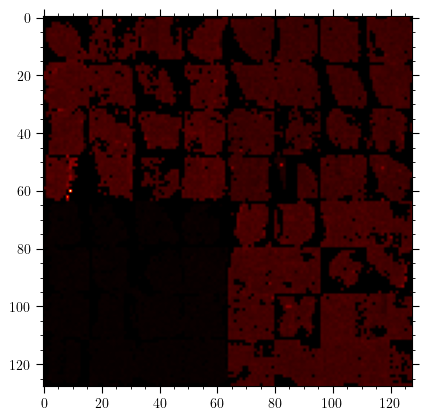

In [ ]:
dpi = fits.open('test/dpigen_out.dpi')
dpi.info()
median, mean, std = sigma_clipped_stats(dpi[5].data, sigma=3.0)
median1, mean1, std1 = sigma_clipped_stats(dpi[1].data, sigma=3.0)
plt.imshow(dpi[5].data, cmap='gist_heat')

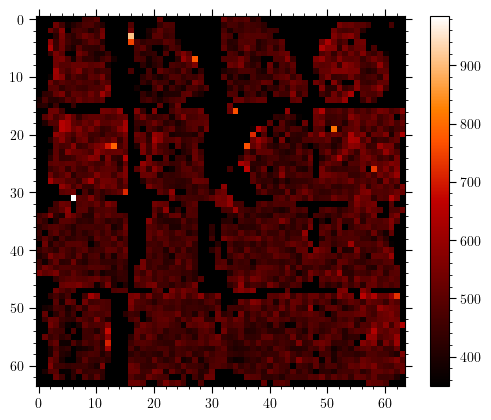

In [ ]:
sub = dph[1].data  - dpi[1].data
median, mean, std = sigma_clipped_stats(sub, sigma=3.0)
plt.imshow(sub, cmap='gist_heat', vmin = median)
plt.colorbar()

In [ ]:
mkf = fits.open('data/AS1A06_002T02_9000003206_21631czt_level2.mkf')
mkf.info()
mkf_data = mkf[1].data
print(mkf_data['TIME'][0])

Filename: data/AS1A06_002T02_9000003206_21631czt_level2.mkf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  MKF           1 BinTableHDU    219   7241R x 69C   [D, 4D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, 1B, E, J, E, E, E, E, J, E, E, J, 1B, E, J, E, E, E, E, J, E, E, J, 1B, E, J, E, E, E, E, J, E, E, J, 1B, E, J, E, E, E, E, J, E, E, J]   
307370636.0


In [ ]:
livetime = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_bc_livetime.fits')
livetime.info()
livetime_data = livetime[1].data
print(livetime_data['TIME'][0])

Filename: data/AS1A06_002T02_9000003206_21631cztM0_level2_bc_livetime.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   ()      
  1  Q0            1 BinTableHDU     16   7244R x 2C   [D, E]   
  2  Q1            1 BinTableHDU     16   7244R x 2C   [D, E]   
  3  Q2            1 BinTableHDU     16   7244R x 2C   [D, E]   
  4  Q3            1 BinTableHDU     16   7245R x 2C   [D, E]   
307370634.5
